# Novel applications of Argovis

Argovis' focus on search and indexing of Earth system data makes it especially well suited to a number of cross-referencing, filtration and summary tasks. While plots in this section could in principle be built from any data service providing this data, Argovis serves the relevant data for each in one or a small number of API calls, with a minimum of superfluous data downloaded.

In [58]:
from argovisHelpers import helpers as avh
import datetime, pandas, matplotlib, scipy, numpy, sys, copy
import matplotlib.pyplot as plt

sys.path.insert(0, '../dataset_specific_notebooks')
import helpers

API_ROOT='https://argovis-api.colorado.edu/'
API_KEY='2bb0aacd62cd0c13ecc7067a184c50ed38c1f0fa'

## Data reduction and identificaiton

One of the most basic tasks any data consumer must perform is data reduction: picking through a dataset to identify items relevant to the task at hand. This step is often nescessary before even beginning a study in earnest, to determine if there are even enough available measurements to make meaningful inquiry on the topic. This is a fundamental search task, and is well supported by Argovis' indexes. As an example, suppose we were interested in Argo BGC floats measuring dissolved oxygen off the Canadian Pacific coast, near the surface and of good QC. Let's begin with a timeseries of such measurements, to understand when such data might be available:

In [80]:
natlantic = [[-52.91015625000001,57.57635026510582],[-47.4609375,58.59841337380398],[-41.13281250000001,58.96285043960036],[-36.12304687500001,58.73552560169896],[-28.828125000000004,58.781109991263875],[-24.433593750000004,58.91750479454867],[-17.929687500000004,58.82663462015099],[-12.216796875000002,58.50670551226914],[-12.392578125,41.263494202188674],[-20.126953125000004,41.06499545917395],[-28.388671875000004,41.592988409051024],[-37.44140625000001,40.865895731685946],[-45.87890625,41.78988186577712],[-52.11914062500001,41.724317678639935],[-52.91015625000001,57.57635026510582]]
#region = [[-147.77192892212193,58.2561939596948],[-174.9692847828361,50.41495201338739],[-158.39026090688225,29.59904295656598],[-121.46755821519557,37.70790240715725],[-123.94452001695444,53.77976917731297],[-139.0032483566941,61.4403423354114],[-147.77192892212193,58.2561939596948]]

argo_doxy = {
    'startDate': '2000-01-01T00:00:00Z',
    'endDate': '2021-01-01T00:00:00Z',
    'polygon': region,
    'presRange': '0,100',
    'compression': 'minimal',
    'data': 'doxy,1'
}

floats = avh.query('argo', options=argo_doxy, apikey=API_KEY, apiroot=API_ROOT, verbose=True)

https://argovis-api.colorado.edu/argo?startDate=2000-01-01T00:00:00Z&endDate=2021-01-01T00:00:00Z&polygon=[[-147.77192892212193,+58.2561939596948],+[-174.9692847828361,+50.41495201338739],+[-158.39026090688225,+29.59904295656598],+[-121.46755821519557,+37.70790240715725],+[-123.94452001695444,+53.77976917731297],+[-139.0032483566941,+61.4403423354114],+[-147.77192892212193,+58.2561939596948]]&presRange=0,100&compression=minimal&data=doxy,1
The temporospatial extent of your request is enormous! If you are using the query helper, it will now try to slice this request up for you. Try setting verbose=true to see how it is slicing this up.
https://argovis-api.colorado.edu/argo?startDate=2000-01-01T00:00:00.000000Z&endDate=2007-08-11T00:00:00.000000Z&polygon=[[-147.77192892212193,+58.2561939596948],+[-174.9692847828361,+50.41495201338739],+[-158.39026090688225,+29.59904295656598],+[-121.46755821519557,+37.70790240715725],+[-123.94452001695444,+53.77976917731297],+[-139.0032483566941,+61.4403

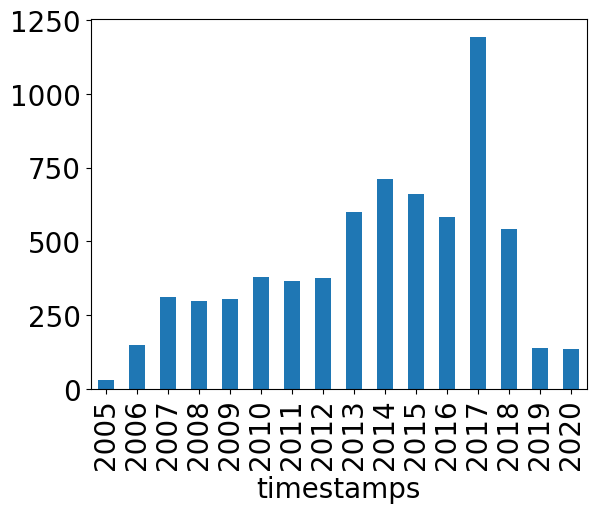

In [81]:
df = helpers.mapping_df(floats)
df['timestamps'].groupby([df["timestamps"].dt.year]).count().plot(kind="bar")
matplotlib.pyplot.savefig('bgcrates.png', bbox_inches='tight')

We quickly see that data collection by the Argo BGC array started to ramp up in earnest in 2006, and carried on through 2018; let's map these profiles, then fetch and plot the dissolved oxygen as a function of pressure and time:

/usr/local/lib/python3.9/site-packages/cartopy/crs.py:245: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(multi_line_string) > 1:
/usr/local/lib/python3.9/site-packages/cartopy/crs.py:256: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  line_strings = list(multi_line_string)
/usr/local/lib/python3.9/site-packages/cartopy/crs.py:256: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  line_strings = list(multi_line_string)
/usr/local/lib/python3.9/site-packages/cartopy/crs.py:297: ShapelyDeprecationWarnin

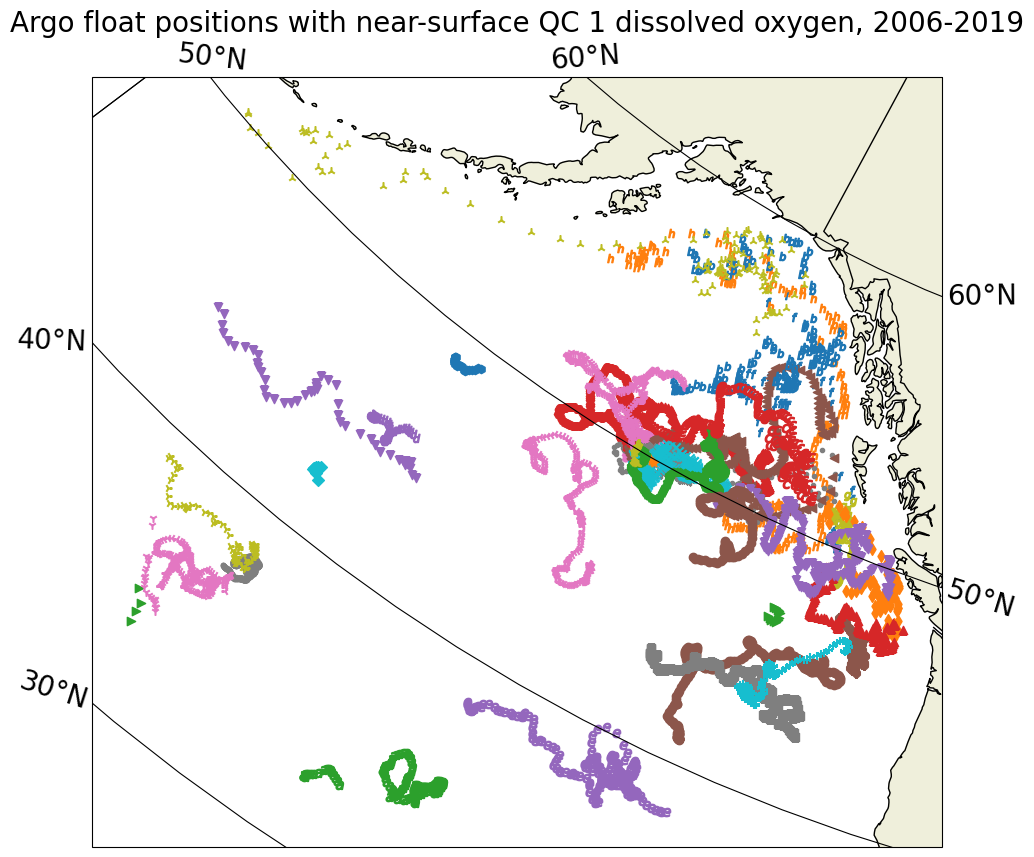

In [87]:
f = []
for x in floats:
    q = copy.deepcopy(x)
    q[3] = avh.parsetime(q[3])
    if avh.parsetime('2006-01-01T00:00:00Z') <= q[3] and avh.parsetime('2019-01-01T00:00:00Z') > q[3]:
        f.append(q)

float_longitudes = [x[1] for x in f]
float_latitudes  = [x[2] for x in f]
float_id = [x[0].split('_')[0] for x in f]

## choose markers on map categorically by float ID
id_markermap = helpers.marker_map(set(float_id))
id_markers = [id_markermap[x] for x in float_id]

helpers.simple_map(float_longitudes,float_latitudes,markers=id_markers, title='Argo float positions with near-surface QC 1 dissolved oxygen, 2006-2019')
matplotlib.pyplot.savefig('mapdoxy.png', bbox_inches='tight')

There's a lot of activity in a smaller region nearer the coast; if we focus there over a longer time period, we may be able to see a seasonal cycle:

In [83]:
focus_region = [[-150,45],[-130,55]]
northern_doxy_params = {
    'startDate': '2006-01-01T00:00:00Z',
    'endDate': '2019-01-01T00:00:00Z',
    'box': focus_region,
    'data': 'doxy,1',
    'presRange': '0,2000'
}
northern_doxy = avh.query('argo', options=northern_doxy_params, apikey=API_KEY, apiroot=API_ROOT, verbose=True)

https://argovis-api.colorado.edu/argo?startDate=2006-01-01T00:00:00Z&endDate=2019-01-01T00:00:00Z&box=[[-150,+45],+[-130,+55]]&data=doxy,1&presRange=0,2000


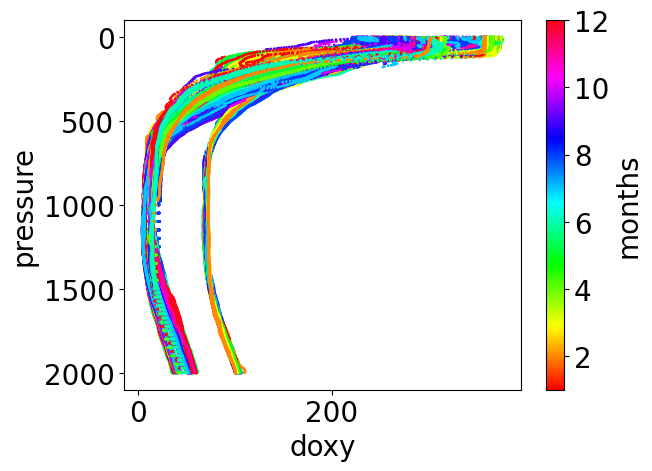

In [85]:
northern_doxy = [x for x in northern_doxy if len(x['data'][0])>200]
df = helpers.level_df(northern_doxy, ['pressure', 'doxy', 'months'])
plot = df.plot(kind='scatter', x='doxy', y='pressure', c='months', colormap='hsv', s=1);
plot.invert_yaxis()
matplotlib.pyplot.savefig('doxyprof.png', bbox_inches='tight')

In [86]:
len(northern_doxy)

750

['6902976_001D']


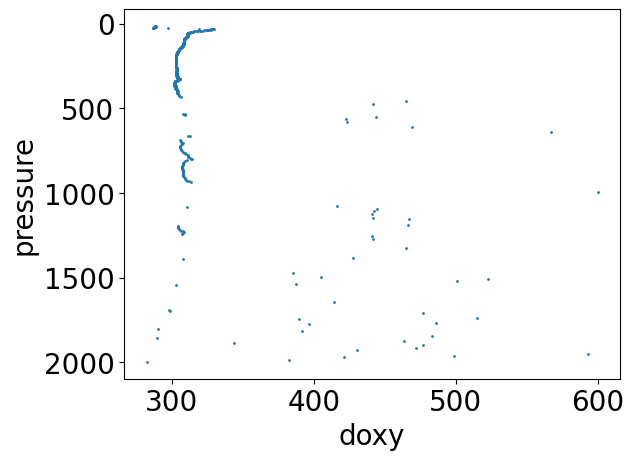

In [37]:
too_much_doxy = [x for x in northern_doxy if any(i > 500 for i in x['data'][0])]
print([x['_id'] for x in too_much_doxy])

df = helpers.level_df(too_much_doxy, ['pressure', 'doxy', 'months'])
plot = df.plot(kind='scatter', x='doxy', y='pressure', colormap='hsv', s=1);
plot.invert_yaxis()
matplotlib.pyplot.savefig('doxyprof.png', bbox_inches='tight')

892


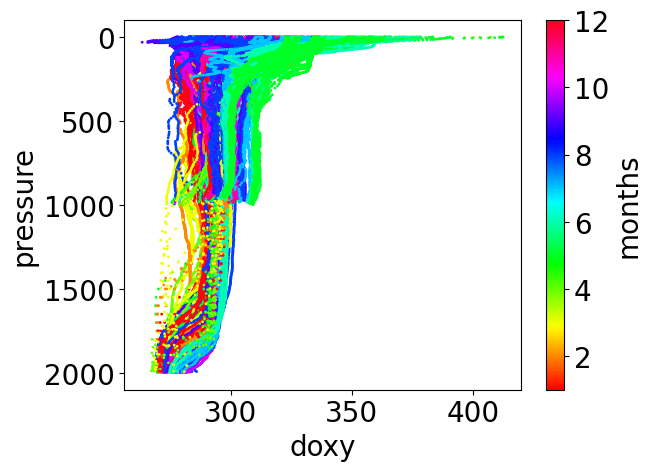

In [41]:
civilized_doxy = [x for x in northern_doxy if x['data_info'][2][0][1] == 'D']
print(len(civilized_doxy))

df = helpers.level_df(civilized_doxy, ['pressure', 'doxy', 'months'])
plot = df.plot(kind='scatter', x='doxy', y='pressure', c='months', colormap='hsv', s=1);
plot.invert_yaxis()
matplotlib.pyplot.savefig('doxyprof.png', bbox_inches='tight')

Note that these plots were generated with only three API calls (we could even have skipped the first one generating the timeseries, if we knew a priori we were interested in a particular time period, as is often the case), and furthermore only downloaded profiles and measurements of interest.

## Colocation, cross-referencing and discovery

One common task sought by data consumers is the ability to cross-reference one dataset with another, and colocate measurements temporospatially for cross-checks, validations and improved statistical confidence in those measurements. Argovis' semi-consistent schema and API structure makes this a straightforward task. The astute reader may note that many of the BGC profiles mapped above pass near the A25 line; let's therefore look for CCHDO ship-based profiles coincident in a broad temporospatial envelope (within 50 km and two days) with any of our dissolved oxygen profiles above:

In [88]:
colo_ships = []
colo_bgc = []
for argo_meas in northern_doxy: #float_profiles:
    cchdo_param = {
        "center": str(argo_meas['geolocation']['coordinates'][0]) + ',' + str(argo_meas['geolocation']['coordinates'][1]),
        "radius": 50,
        "startDate": avh.parsetime((avh.parsetime(argo_meas['timestamp']) + datetime.timedelta(days=-2))),
        "endDate": avh.parsetime((avh.parsetime(argo_meas['timestamp']) + datetime.timedelta(days=+2))),
        "data": 'all'
    }

    prox = avh.query('cchdo', options=cchdo_param, apikey=API_KEY, apiroot=API_ROOT)
    
    if len(prox) != 0:
        colo_ships = colo_ships + prox
        colo_bgc.append(argo_meas) 

In [89]:
print('number of colocated ship profiles:', len(colo_ships))
print('unique metadata records:', set([item for sublist in [x['metadata'] for x in colo_ships] for item in sublist]))
print('ids of colocated BGC profiles:', [x['_id'] for x in colo_bgc])

number of colocated ship profiles: 44
unique metadata records: {'2344_m0', '2381_m0', '2327_m0', '2332_m0', '2330_m0'}
ids of colocated BGC profiles: ['5905988_033', '5905988_032', '5905988_031', '4901790_107', '4902414_000', '4901786_000', '5903713_002', '5903713_001']


We identify 16 ship-based profiles somewhat near Argo BGC profiles, all with the same metadata record, indicating they came from the same cruise; what's more, the IDs of the related BGC profiles (structured as probeID_cycleNumber) are all first ascending cycles, and come from nearly consecutive probe IDs. We suspect these BGC probes may have been actually deployed from this cruise; we can invert our colocation and relax the dissolved oxygen QC constraint to see if any other profiles from these probes were collected on immediate deployment; let's start by getting location data for every station on this cruise:

In [10]:
cruise_944_params = {
    'cchdo_cruise': 944,
    'data': 'all'
}

cruise_944 = avh.query('cchdo', options=cruise_944_params, apikey=API_KEY, apiroot=API_ROOT)

Now let's invert the colocation: let's look for any Argo BGC profile within 10 km and 12 hours of any station on CCHDO cruise 944:

In [11]:
colo_bgc_loose = []
for ship_meas in cruise_944:
    argo_param = {
        "center": str(ship_meas['geolocation']['coordinates'][0]) + ',' + str(ship_meas['geolocation']['coordinates'][1]),
        "radius": 10,
        "startDate": avh.parsetime((avh.parsetime(ship_meas['timestamp']) + datetime.timedelta(hours=-12))),
        "endDate": avh.parsetime((avh.parsetime(ship_meas['timestamp']) + datetime.timedelta(hours=+12))),
        "source": 'argo_bgc'
    }

    prox = avh.query('argo', options=argo_param, apikey=API_KEY, apiroot=API_ROOT)
    
    if len(prox) != 0:
        colo_bgc_loose = colo_bgc_loose + prox 

In [12]:
print('ids of BGC profiles near cruise 944 stations:', [x['_id'] for x in colo_bgc_loose])

ids of BGC profiles near cruise 944 stations: ['5902269_000D', '5902297_000D', '5902298_000D', '5902299_000D', '5902300_000D', '5902301_000D', '5902302_000D', '5902303_000D', '5902304_000D', '5902305_000D', '5902306_000D', '5902307_000D', '5902308_000D']


We see all such profiles are in fact initial descending profiles (indicated by the trailing '000D'). This simple discovery exercise has let us identify colocated oceanic profiles, and confirmed an anticipated relationship between the Argo and CCHDO datasets. Let's conclude this section by mapping the BGC profiles alongside the cruise 944 stations:

/books/helpers.py:38: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "-k" (-> color='k'). The keyword argument will take precedence.
  plt.plot(polygon_lon_lat(str(polygon))['lon'],polygon_lon_lat(str(polygon))['lat'],'-k',transform=ccrs.PlateCarree(), linewidth=polygonweight, color='red')


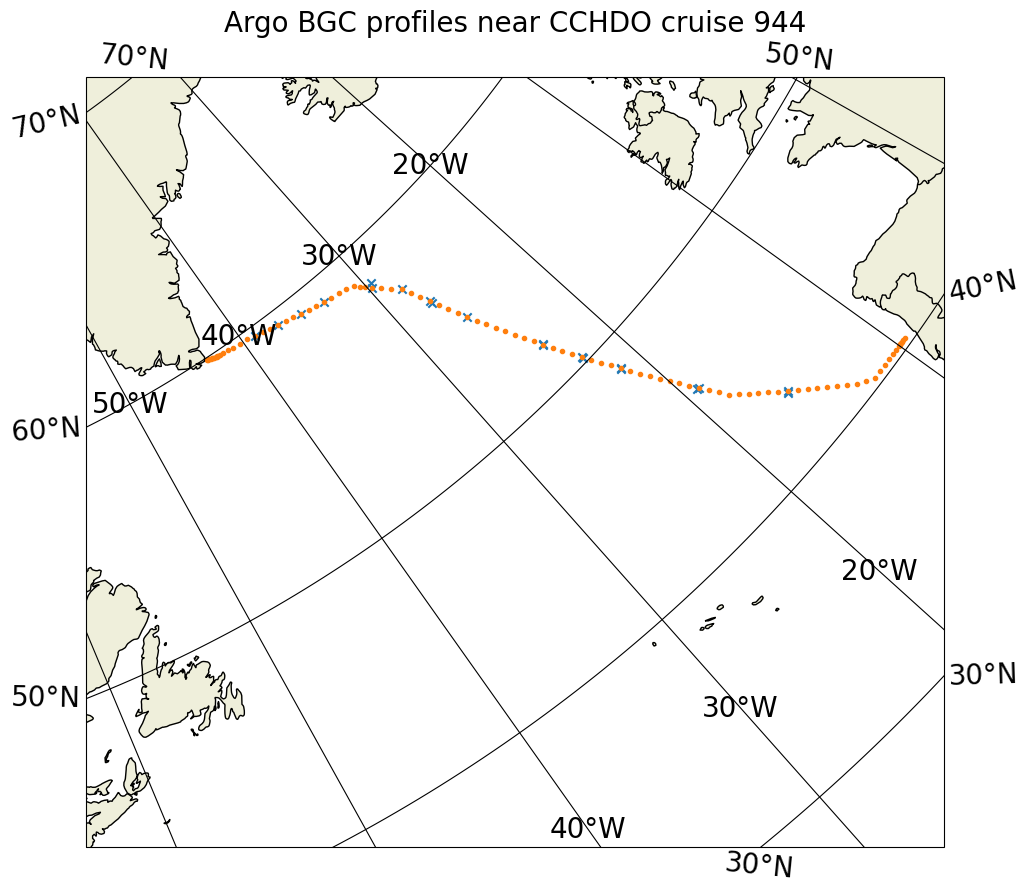

In [13]:
cruise_longitudes = [x['geolocation']['coordinates'][0] for x in cruise_944]
cruise_latitudes  = [x['geolocation']['coordinates'][1] for x in cruise_944]
cruise_markers = ['.']*len(cruise_944)

bgc_longitudes = [x['geolocation']['coordinates'][0] for x in colo_bgc+colo_bgc_loose]
bgc_latitudes  = [x['geolocation']['coordinates'][1] for x in colo_bgc+colo_bgc_loose]
bgc_markers = ['x']*len(colo_bgc+colo_bgc_loose)

longitudes = cruise_longitudes + bgc_longitudes
latitudes = cruise_latitudes + bgc_latitudes
markers = cruise_markers + bgc_markers

helpers.simple_map(longitudes,latitudes,markers=markers, polygon=natlantic, polygonweight=0, title='Argo BGC profiles near CCHDO cruise 944')
matplotlib.pyplot.savefig('bgccolo.png', bbox_inches='tight')

## Regular interpolations

Another relatively easy task to accomplish with Argovis-formatted data is to produce data interpolated to a regular grid. Let's look at CCHDO cruise 2507, a 2020 occupancy of A05:

In [14]:
A05_params = {
    'cchdo_cruise': 2507,
    'data': 'temperature',
    'presRange': [0,1100]
}

A05 = avh.query('cchdo', options=A05_params, apikey=API_KEY, apiroot=API_ROOT)

Note we're going to get pressure and temperature vectors limited to a pressure range suitable for passing directly into a scipy interpolator. Let's do a pchip interpolation of temperature to levels in intervals of 5 decibar, from 10 to 1000 decibar:

In [15]:
levels = list(range(0,1000,5))
def interpolate_profile(raw, variable, levels):
    # raw: a single argovis profile as returned from the API, including a data_info key
    # variable: anything found in data_info[0] in the provided profile; the variable to interpolate
    # levels: the standard levels to interp to.
    
    # extract pressure and the variable to interpolate
    var_idx = raw['data_info'][0].index(variable)
    pressure_idx = raw['data_info'][0].index('pressure')
    var = raw['data'][var_idx]
    pressure = raw['data'][pressure_idx]
    
    # don't evaluate the interpolation outside the range of available pressures
    lvl = [x if x>pressure[0] and x<pressure[-1] else numpy.NAN for x in levels]
    
    return list(scipy.interpolate.pchip_interpolate(pressure, var, lvl))

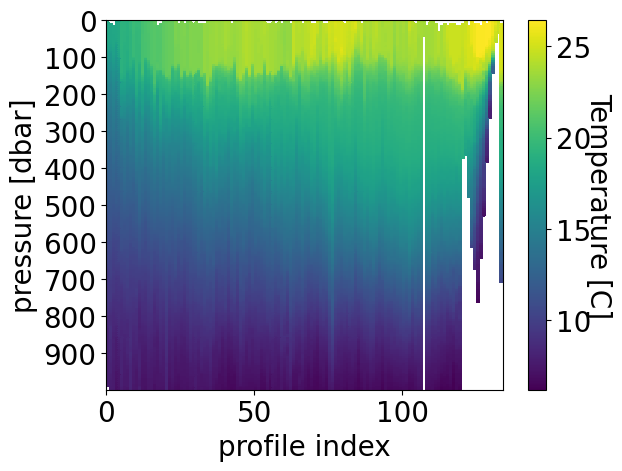

In [16]:
temp_interp = [ interpolate_profile(x, 'temperature', levels) for x in A05 ]
temp_interp = numpy.array(temp_interp).T
columns = [x['_id'][18:33] for x in A05]
df = pandas.DataFrame(temp_interp, index=levels, columns=columns)
plt.pcolor(df)
tickidx = numpy.arange(0, len(df.index), 20)
plt.yticks(tickidx, [df.index[x] for x in tickidx])
plt.ylabel('pressure [dbar]')
plt.xlabel('profile index')
plt.gca().invert_yaxis()
cbar = plt.colorbar()
cbar.set_label('Temperature [C]', rotation=270,labelpad=15)
plt.show()
matplotlib.pyplot.savefig('interptemp.png', bbox_inches='tight')

## Fleet-level summaries

Another interesting class of data reduction problem are large scale summaries: analyzing and visualizing summary data for the entire globe, or the entire history of a program like Argo. Let's begin similarly to above, by mapping all the Argo BGC profiles from 2020 that have QC 1 dissolved oxygen:

In [17]:
datafilter = {
    'startDate': '2020-01-01T00:00:00Z',
    'endDate': '2021-01-01T00:00:00Z',
    'data': 'doxy,1',
    'presRange': [100,150],
    'compression': 'minimal'
}

doxy = avh.query('argo', options=datafilter, apikey=API_KEY, apiroot=API_ROOT)

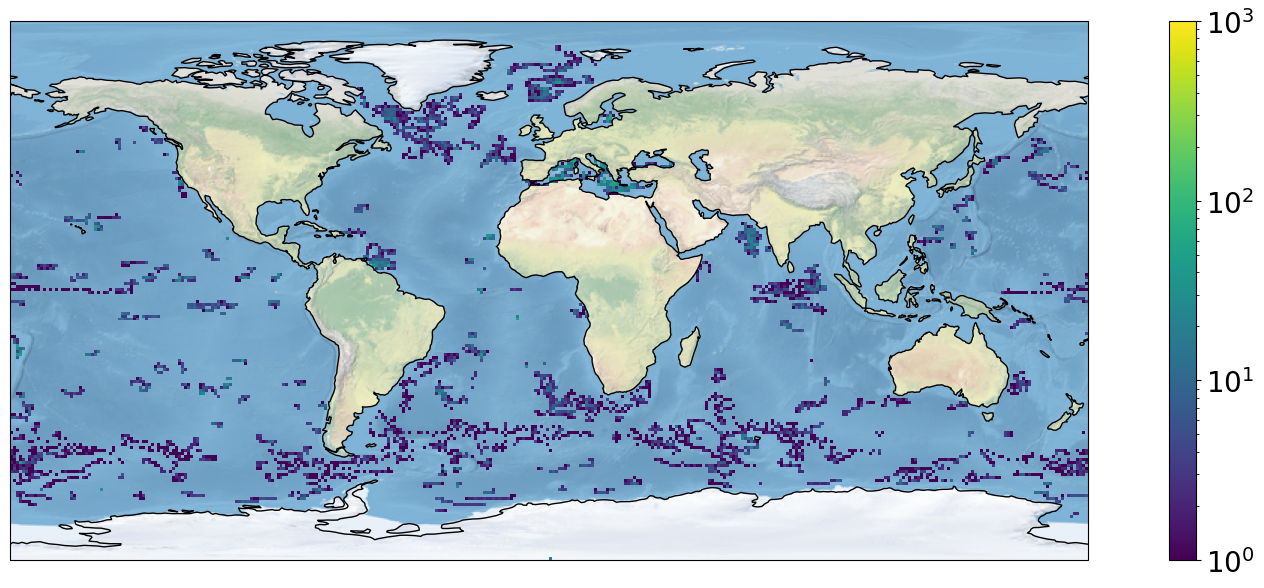

In [18]:
df = helpers.mapping_df(doxy)
helpers.map_count_in_bins(df,datafilter['startDate'],datafilter['endDate'])
matplotlib.pyplot.savefig('doxymap.png', bbox_inches='tight')

We can also make timeseries representations of metadata relatively easily. For example, let's make a timeseries of Argo program profiles (core versus BGC versus deep) in use by the Argo array:

In [3]:
# this section takes some time.

In [3]:
argo_profile_params = {
    'startDate': '2010-01-01T00:00:00Z',
    'endDate': '2020-01-01T00:00:00Z',
    'compression': 'minimal'
}

argo_profiles = avh.query('argo', options=argo_profile_params, apikey=API_KEY, apiroot=API_ROOT, verbose=True)

https://argovis-api.colorado.edu/argo?startDate=2010-01-01T00:00:00Z&endDate=2020-01-01T00:00:00Z&compression=minimal
The temporospatial extent of your request is enormous! If you are using the query helper, it will now try to slice this request up for you. Try setting verbose=true to see how it is slicing this up.
https://argovis-api.colorado.edu/argo?startDate=2010-01-01T00:00:00.000000Z&endDate=2010-03-14T00:00:00.000000Z&compression=minimal
https://argovis-api.colorado.edu/argo?startDate=2010-03-14T00:00:00.000000Z&endDate=2010-05-25T00:00:00.000000Z&compression=minimal
https://argovis-api.colorado.edu/argo?startDate=2010-05-25T00:00:00.000000Z&endDate=2010-08-05T00:00:00.000000Z&compression=minimal
https://argovis-api.colorado.edu/argo?startDate=2010-08-05T00:00:00.000000Z&endDate=2010-10-16T00:00:00.000000Z&compression=minimal
https://argovis-api.colorado.edu/argo?startDate=2010-10-16T00:00:00.000000Z&endDate=2010-12-27T00:00:00.000000Z&compression=minimal
https://argovis-api.col

In [21]:
# def categorize_argo(source):
#     if 'argo_core' in source and not 'argo_bgc' in source and not 'argo_deep' in source:
#         return 'core'
#     elif 'argo_bgc' in source and not 'argo_deep' in source:
#         return 'bgc'
#     elif 'argo_deep' in source and not 'argo_bgc' in source:
#         return 'deep'
#     elif 'argo_bgc' in source and 'argo_deep' in source:
#         return 'deep_bgc'

# ts = [ [avh.parsetime(x[3]), categorize_argo(x[4]) ] for x in argo_profiles ]
# df = pandas.DataFrame(ts, columns=['timestamps', 'source'])

In [6]:
def categorize_argo(source):
    if 'argo_core' in source and not 'argo_bgc' in source and not 'argo_deep' in source:
        return 'core'
    elif 'argo_bgc' in source and not 'argo_deep' in source:
        return 'bgc'
    elif 'argo_deep' in source and not 'argo_bgc' in source:
        return 'deep'
    elif 'argo_bgc' in source and 'argo_deep' in source:
        return 'deep_bgc'

ts_core = [ [avh.parsetime(x[3]), 'core' ] for x in argo_profiles if 'argo_core' in x[4] and not 'argo_deep' in x[4]]
ts_bgc = [ [avh.parsetime(x[3]), 'bgc' ] for x in argo_profiles if 'argo_bgc' in x[4] and not 'argo_deep' in x[4]]
ts_deep = [ [avh.parsetime(x[3]), 'deep' ] for x in argo_profiles if 'argo_deep' in x[4] and not 'argo_bgc' in x[4]]
ts_bgcdeep = [ [avh.parsetime(x[3]), 'deep_bgc' ] for x in argo_profiles if 'argo_bgc' in x[4] and 'argo_deep' in x[4]]
    
ts = ts_core + ts_bgc + ts_deep + ts_bgcdeep
df = pandas.DataFrame(ts, columns=['timestamps', 'source'])

In [5]:
def categorical_df(df, startYear, endYear, category):
    timebounds = []
    for y in range(startYear, endYear+2):
        timebounds.append(avh.parsetime(f'{y}-01-01T00:00:00Z'))
    catdf = pandas.crosstab(pandas.cut(df['timestamps'],timebounds), df[category])
    catdf.index = catdf.index.rename_categories(range(startYear,endYear+1))
    
    return catdf

In [8]:
catdf = categorical_df(df,2010,2020,'source')

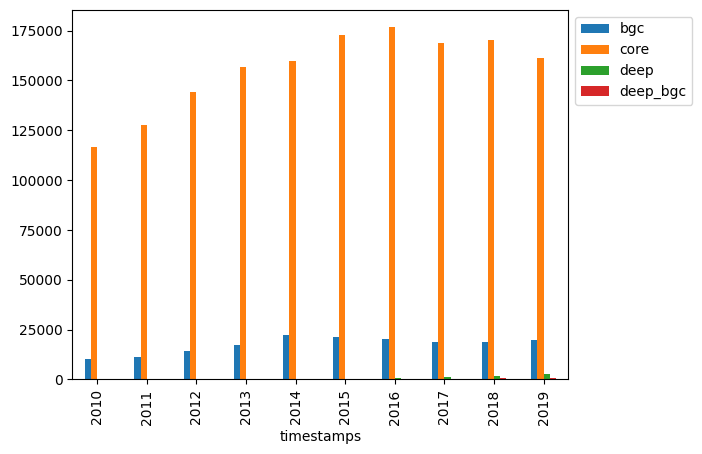

In [9]:
catdf.plot.bar().legend(bbox_to_anchor=(1.0, 1.0))
matplotlib.pyplot.savefig('.png', bbox_inches='tight')

We can similarly construct a timeseries of metadata categories from metadata found on the metadata docs. Here the convenience switch `batchmeta` comes in handy; the query below will return all the metadata docs corresponding to the data documents returned without the `batchmeta` flag set:

In [2]:
argo_2010_fleet_metaops = {
    'startDate': '2010-01-01T00:00:00Z',
    'endDate': '2020-01-01T00:00:00Z',
    'batchmeta': 'true'
}

argo2010meta = avh.query('argo', options=argo_2010_fleet_metaops, apikey=API_KEY, apiroot=API_ROOT, verbose=True)

https://argovis-api.colorado.edu/argo?startDate=2010-01-01T00:00:00Z&endDate=2020-01-01T00:00:00Z&batchmeta=true
The temporospatial extent of your request is enormous! If you are using the query helper, it will now try to slice this request up for you. Try setting verbose=true to see how it is slicing this up.
https://argovis-api.colorado.edu/argo?startDate=2010-01-01T00:00:00.000000Z&endDate=2010-03-14T00:00:00.000000Z&batchmeta=true
https://argovis-api.colorado.edu/argo?startDate=2010-03-14T00:00:00.000000Z&endDate=2010-05-25T00:00:00.000000Z&batchmeta=true
https://argovis-api.colorado.edu/argo?startDate=2010-05-25T00:00:00.000000Z&endDate=2010-08-05T00:00:00.000000Z&batchmeta=true
https://argovis-api.colorado.edu/argo?startDate=2010-08-05T00:00:00.000000Z&endDate=2010-10-16T00:00:00.000000Z&batchmeta=true
https://argovis-api.colorado.edu/argo?startDate=2010-10-16T00:00:00.000000Z&endDate=2010-12-27T00:00:00.000000Z&batchmeta=true
https://argovis-api.colorado.edu/argo?startDate=2010-

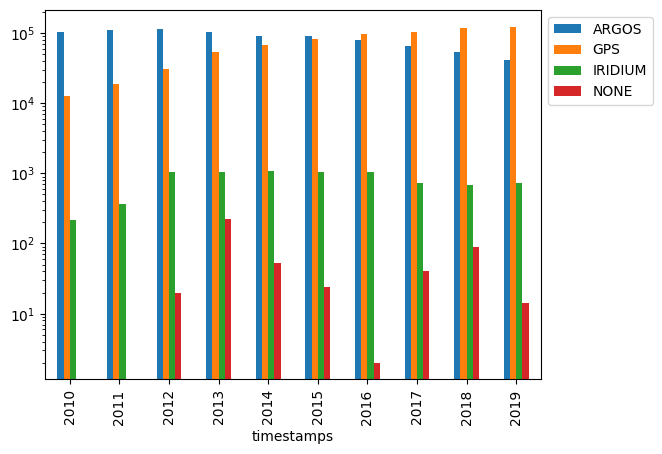

In [6]:
metalookup = {x['_id']: x for x in argo2010meta}
ts = [ [avh.parsetime(x[3]), metalookup[x[5][0]]['positioning_system'] ] for x in argo_profiles]
del metalookup
df = pandas.DataFrame(ts, columns=['timestamps', 'positioning_system'])
del ts
catdf = categorical_df(df,2010,2020,'positioning_system')
catdf.plot.bar(logy=True).legend(bbox_to_anchor=(1.0, 1.0))

In [8]:
plt.savefig('positioning_system.png', bbox_inches='tight')

<Figure size 640x480 with 0 Axes>